In [3]:
from PIL import Image
import numpy as np

# 画像を読み取る
im1 = np.array(Image.open('./image1.png'))
im2 = np.array(Image.open('./image2.png'))

im1_one = im1.reshape(-1).astype(np.float64)
im1_shape = im1.shape
im2_one = im2.reshape(-1).astype(np.float64)
im2_shape = im2.shape

# 必要な関数
# 正規化する関数
def normalization(m):
    m[0] = m[0] / np.linalg.norm(m[0])
    m[1] = m[1] / np.linalg.norm(m[1])
    return m

# 収束条件を管理する関数
def change(w_before, w):
    wp = w_before -w
    if abs(wp[0, 0]) < 0.0001 and abs(wp[0, 1]) < 0.0001 and abs(wp[1, 0]) < 0.0001 and abs(wp[1, 1]) < 0.0001:
        return 1
# ICAの関数
def ica(array1, array2):
    # データの長さを取得
    N = len(array1)
   
    # 平均を0にする
    ave_1 = np.mean(array1)
    ave_2 = np.mean(array2)
    array1 -= ave_1
    array2 -= ave_2

    X = np.matrix([array1, array2])
    
    # シグマ行列の計算
    cov_mat = np.matrix([[np.dot(array1, array1), np.dot(array1, array2)], [np.dot(array2, array1), np.dot(array2, array2)]]) * (1/N)

    # 固有値の導出
    eig_val = np.linalg.eig(cov_mat)[0]

    # 固有ベクトル(対角行列)の導出
    E = np.linalg.eig(cov_mat)[1]    

    D = np.matrix([[eig_val[0], 0], [0, eig_val[1]]])
    D_2 = np.matrix([[(eig_val[0])**(-0.5), 0], [0, (eig_val[1])**(-0.5)]])

    # V, Z行列の導出
    v_i = np.dot(E, D_2)
    V = np.dot(v_i, E.T)

    # Z行列の導出
    Z = np.dot(V, X)

    # Zの共分散行列が単位行列になることを確認
    z0, z1 = np.array(Z[0]), np.array(Z[1])
    Z_cov = np.matrix([[float(np.dot(z0, z0.T)), float(np.dot(z0, z1.T))], [float(np.dot(z1, z0.T)), float(np.dot(z1, z1.T))]]) * (1/N)

    w = np.matrix([[-10.0,3.0], [1.0, -2.0]])
    w = normalization(w)
    
    cnt = 0
    while True:
        w_before = w.copy()
        for i in range(2):
            a = np.dot(w[i], Z)
            a = pow(np.array(a), 3)
            a = np.array(a).flatten()
            ll_1 = np.array([Z[0, i] * a[i] for i in range(N)])
            ll_2 = np.array([Z[1, i] * a[i] for i in range(N)])
            val0 = np.sum(ll_1) / N
            val1 = np.sum(ll_2) / N
            w[i] = np.array([val0, val1]) - w[i] *3
        w = normalization(w)
        if w[0, 0] < 0:
            w *= (-1)
        if change(w_before, w) == 1:
            break

    # 信号源データの取得
    Y = np.dot(w, Z)
    return Y

y = ica(im1_one, im2_one)

# 正規化
diff_1 = np.max(y[0]) - np.min(y[0])
y[0] = (y[0] - np.min(y[0])) / diff_1
diff_2 = np.max(y[1]) - np.min(y[1])
y[1] = (y[1] - np.min(y[1])) / diff_2

# 画素にする
y[0] = y[0]  *255
y[1] = y[1]  *255

# 形を直す
pic_1 = Image.fromarray(y[0].reshape(im1_shape).astype(np.uint8))
pic_2 = Image.fromarray(y[1].reshape(im2_shape).astype(np.uint8))

# 保存
pic_1.save('./out_img_1.png')
pic_2.save('./out_img_2.png')

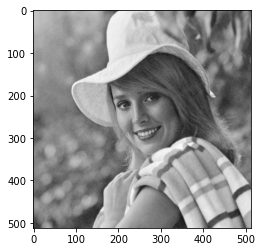

In [4]:
import matplotlib.pyplot as plt
plt.imshow(pic_1, cmap = 'gray')
plt.show()

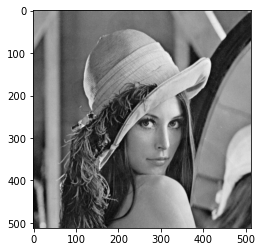

In [5]:
plt.imshow(pic_2, cmap = 'gray')
plt.show()